In [33]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
import warnings
from xgboost import XGBRegressor, XGBClassifier
warnings.filterwarnings('ignore')
%matplotlib inline


# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [34]:
profile[profile['age']== 118].drop(['became_member_on' ,'id'], axis=1)

,gender,age,income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN
...,...,...,...
16980,None,118,NaN
16982,None,118,NaN
16989,None,118,NaN
16991,None,118,NaN


In [35]:
profile[(profile['age'] > 80) & (profile['age'] < 118)]

,gender,age,id,became_member_on,income
33,F,96,868317b9be554cb18e50bc68484749a2,20171117,89000.0
94,F,89,4264b1d027cc493281bba4f44bfedaca,20171114,87000.0
98,F,90,1c587de019994f93a242c6864fd7bc55,20151210,98000.0
126,M,83,4c29d22467af4d7faa137c4eedd65340,20180127,46000.0
131,F,89,3dae0eadb47149b0b9b548d14548524b,20180114,65000.0
...,...,...,...,...,...
16914,M,87,d1c4500ace2e45e9a45d3cd2fccac8d8,20140920,59000.0
16933,M,85,a65353ea28ff442aabfb39eb974326e3,20161001,96000.0
16938,F,89,da7bf9d84fd74a72bdee595007bcca7a,20170413,68000.0
16981,M,84,1966fa40d2f84620b2b1b9b64f8e0209,20160629,93000.0


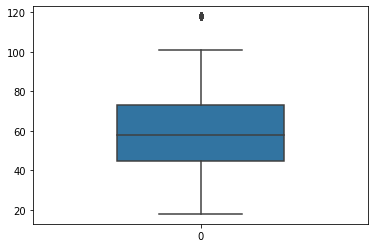

In [36]:
sns.boxplot(profile['age'], width=0.5);

People above 80 are considered as outliers

In [37]:
def rename_cols(df, new_cols_name):
    df= df.rename(columns = new_cols_name)
    return df 

In [38]:
new_cols_name = {'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'}
cleaned_portfolio = rename_cols(portfolio, new_cols_name )

In [39]:
cleaned_portfolio.head()

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [40]:
cols_profile = {'id':'customer_id' , 'income':'customer_income'}
cleaned_profile = rename_cols(profile, cols_profile )
cleaned_profile.columns

Index(['gender', 'age', 'customer_id', 'became_member_on', 'customer_income'], dtype='object')

In [41]:
def cleaning_profile(df):
    df.replace(118, np.nan , inplace=True)
    #replace NaN age values with mean age
    df['age'] = df['age'].fillna(df['age'].mean())
    #replace missing income values with mean income
    df['customer_income'] = df['customer_income'].fillna(df['customer_income'].mean())
    #replace missing gender values with mode i.e. most frequent gender
    mode = df['gender'].mode()[0]
    df['gender'] = df['gender'].fillna(mode)
    
    #remove outliers
    df = df[df['age'] <= 80]
    df['age'] = df['age'].astype(int)
    
    #add Age_group column
    df.loc[(df.age < 20) , 'Age_group'] = 'Under 20'
    df.loc[(df.age >= 20) & (df.age <= 45) , 'Age_group'] = '20-45'
    df.loc[(df.age >= 46) & (df.age <= 60) , 'Age_group'] = '46-60'
    df.loc[(df.age >= 61) , 'Age_group'] = '61-80'
    df.drop('age',axis=1,inplace=True)
    return df

In [42]:
cleaned_profile = cleaning_profile(cleaned_profile)
cleaned_profile.head()

,gender,customer_id,became_member_on,customer_income,Age_group
0,M,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,46-60
1,F,0610b486422d4921ae7d2bf64640c50b,20170715,112000.000000,46-60
2,M,38fe809add3b4fcf9315a9694bb96ff5,20180712,65404.991568,46-60
3,F,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.000000,61-80
4,M,a03223e636434f42ac4c3df47e8bac43,20170804,65404.991568,46-60


In [43]:
transcript_cols = {'person':'customer_id'}
cleaned_transcript = rename_cols(transcript, transcript_cols)
cleaned_transcript.columns

Index(['customer_id', 'event', 'value', 'time'], dtype='object')

In [44]:
def cleaning_transcript(df):
    df['offer_id'] = df['value'].apply(lambda x: x.get('offer_id'))
    df['offer id'] = df['value'].apply(lambda x: x.get('offer id'))
    df['money_gained'] = df['value'].apply(lambda x: x.get('reward'))
    df['money_spent'] = df['value'].apply(lambda x: x.get('amount'))
    
    #move 'offer id' values into 'offer_id'
    df['offer_id'] = df.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)
    #drop 'offer id' column 
    df.drop(['offer id' , 'value'] , axis=1, inplace=True)
    #replace nan
    df.fillna(0 , inplace=True)
    
    return df

In [45]:
cleaned_transcript = cleaning_transcript(cleaned_transcript)
cleaned_transcript.head()

,customer_id,event,time,offer_id,money_gained,money_spent
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


In [46]:
def merge_data(portfolio,profile,transcript):
     merged_df = pd.merge(portfolio, transcript, on='offer_id')
     merged_df = pd.merge(merged_df, profile, on='customer_id')
    
     return merged_df


In [47]:
merged_df = merge_data(cleaned_portfolio, cleaned_profile, cleaned_transcript)
merged_df.head()

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id,customer_id,event,time,money_gained,money_spent,gender,became_member_on,customer_income,Age_group
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,0.0,0.0,M,20170909,100000.0,61-80
1,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,102,0.0,0.0,M,20170909,100000.0,61-80
2,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,504,0.0,0.0,M,20170909,100000.0,61-80
3,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,510,0.0,0.0,M,20170909,100000.0,61-80
4,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer completed,510,10.0,0.0,M,20170909,100000.0,61-80


Build a Machine Learning model to predict response of a customer to an offer

Before building a model, we'll have to clean & prepare the data to fit into the model.

Data Preparation and Cleaning 

Tasks

1.Encode categorical data such as gender, offer type, channel and age groups.

2.Encode the 'event' data to numerical values:
offer received ---> 1
offer viewed ---> 2
offer completed ---> 3

3.Encode offer id and customer id.

4.Drop column 'became_member_on' and add separate columns for month and year.

5.Scale and normalize numerical data.

In [48]:
def cleaning_final_data(df):
    categorical=['offer_type','gender','Age_group']
    df=pd.get_dummies(df,columns=categorical)
    df=df.drop('channels',1).join(df.channels.str.join('|').str.get_dummies())
    df['became_member_on'] = df['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    #add new columns for month & year
    df['month_member'] = df['became_member_on'].apply(lambda x: x.day)
    df['year_member'] = df['became_member_on'].apply(lambda x: x.year)
    #drop became_member_on column
    df.drop('became_member_on',axis=1, inplace=True)    
    
    #process offer_id column
    offerids = df['offer_id'].unique().tolist()
    o_mapping = dict( zip(offerids,range(len(offerids))) )
    df.replace({'offer_id': o_mapping},inplace=True)
    
    #process customer_id column
    cusids = df['customer_id'].unique().tolist()
    c_mapping = dict( zip(cusids,range(len(cusids))) )
    df.replace({'customer_id': c_mapping},inplace=True)
    
    #process numerical variables
    #initialize a MinMaxScaler, then apply it to the features
    scaler = MinMaxScaler() # default=(0, 1)
    numerical = ['customer_income', 'offer_difficulty', 'offer_duration', 'offer_reward', 'time', 'money_gained', 'money_spent']
    df[numerical] = scaler.fit_transform(df[numerical])
    
    #encode 'event' data to numerical values according to task 2
    df['event'] = df['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})
    
    return df

In [49]:
cleaned_data = cleaning_final_data(merged_df)
cleaned_data.head()

,offer_reward,offer_difficulty,offer_duration,offer_id,customer_id,event,time,money_gained,money_spent,customer_income,...,Age_group_20-45,Age_group_46-60,Age_group_61-80,Age_group_Under 20,email,mobile,social,web,month_member,year_member
0,1.0,0.5,0.571429,0,0,1,0.000000,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
1,1.0,0.5,0.571429,0,0,2,0.142857,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
2,1.0,0.5,0.571429,0,0,1,0.705882,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
3,1.0,0.5,0.571429,0,0,2,0.714286,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
4,1.0,0.5,0.571429,0,0,3,0.714286,1.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017


In [50]:
data=cleaned_data.drop('event',axis=1)
label=cleaned_data['event']

In [51]:
X_train,X_test,y_train,y_test=train_test_split(data,label,test_size=0.4,random_state=42)


Metrics

We will consider the F1 score as the model metric to assess the quality of the approach and determine which model gives the best results. It can be interpreted as the weighted average of the precision and recall. The traditional or balanced F-score (F1 score) is the harmonic mean of precision and recall, where an F1 score reaches its best value at 100 and worst at 0.

In [52]:
def train_test(clf):
     train_prediction =  (clf.fit(X_train, y_train)).predict(X_train)
     test_predictions = (clf.fit(X_train, y_train)).predict(X_test)
     train_f1 =  accuracy_score(y_train, train_prediction)*100
     test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
     name = clf.__class__.__name__
    
     return train_f1, test_f1, name

KNeighborsClassifier 

In [53]:
clf_A=KNeighborsClassifier(n_neighbors=5)
a_train_f1, a_test_f1, a_model = train_test(clf_A)


In [54]:
knn = {'Benchmark Model': [ a_model], 'train F1 score':[a_train_f1], 'test F1 score': [a_test_f1]}
benchmark = pd.DataFrame(knn)
benchmark

,Benchmark Model,train F1 score,test F1 score
0,KNeighborsClassifier,54.249161,32.938637


RandomForestClassifier

In [55]:
clf_B = RandomForestClassifier(random_state = 10)
b_train_f1, b_test_f1, b_model = train_test(clf_B)

DecisionTreeClassifier

In [56]:
clf_C = DecisionTreeClassifier(random_state = 10)
c_train_f1, c_test_f1, c_model = train_test(clf_C)

In [58]:
models = {'Model': ['KNeighborsClassifier (Benchmark)', b_model, c_model], 
          'train F1 score ':[a_train_f1, b_train_f1, c_train_f1], 
          'test F1 score': [a_test_f1 , b_test_f1, c_test_f1] }
          
comp = pd.DataFrame(models)
comp

,Model,train F1 score,test F1 score
0,KNeighborsClassifier (Benchmark),54.249161,32.938637
1,RandomForestClassifier,95.419096,72.586585
2,DecisionTreeClassifier,95.421212,85.062379


The validation set (test data set) is used to evaluate the model. Both the models are better than the benchmark. The best score is created by the DecisionTreeClassifier model, as its validate F1 score is 85.10, which is much higher than the benchmark. The RandomForestClassifier model scores good as well compared to the benchmark, with a test F1 score of 69.30. Our problem to solve is not that sensitive which requires very high F1 score, so the scores are good & sufficient and can be used for the classification purpose to predict whether a customer will respond to an offer.